In [ ]:
# ==========================================
# SCRIPT KOREKSI BIAS: STATIC CORRECTION FACTOR
# ==========================================
# Penulis: Jariyan Arifudin
# Metode: Static Bias Correction (Single Global Coefficient)
# Deskripsi: Menghitung satu faktor koreksi dari total data historis
#            dan menerapkannya secara seragam.
# ==========================================

# 1. INSTALL LIBRARY
!pip install rasterio geopandas shapely matplotlib scikit-learn pandas numpy seaborn tqdm folium

import os
import glob
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from google.colab import drive
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

In [ ]:
# ==========================================
# BAGIAN 1: SETUP & KONFIGURASI
# ==========================================

# Mount Google Drive
drive.mount('/content/drive')

# --- DIREKTORI DATA (SESUAIKAN PATH INI) ---
BASE_DIR = '/content/drive/My Drive/Colab Notebooks/Skripsi/'
CHIRPS_DIR = os.path.join(BASE_DIR, 'CHIRPS v3/')
ADMIN_PATH = os.path.join(BASE_DIR, 'Batas Adm Jambi/Adm_Jambi_Prov.shp')
CSV_DIR = os.path.join(BASE_DIR, 'Data Stasiun BWS Sumatera VI/')

# Output Directory (Folder Baru)
output_dir = os.path.join(CHIRPS_DIR, 'bias_corrected_static')
os.makedirs(output_dir, exist_ok=True)

# Rentang wilayah (Bounding Box Jambi)
bbox = box(100.75, -2.75, 104.75, -0.5)
bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox]}, crs='EPSG:4326')

# --- DAFTAR STASIUN ---
# 1. Stasiun Kalibrasi (Untuk menghitung Faktor Global)
bias_stations = [
    "Koto Limau Sering", "Semurup", "Sipin", "Siulak Deras",
    "Dendang", "Pulau Tengah", "Tamiai"
]

# 2. Stasiun Validasi (Untuk uji akurasi)
validation_stations = [
    "Bukit Bulan",
    "Muara Tembesi",
    "Rantau Pandan",
    "Sungai Manau",
    "Tanjung Genting",
    "Muaro Imat",
    "Sungai Bengkal"
]

# Lokasi Koordinat Stasiun (Longitude/X, Latitude/Y)
station_coords = {
    "Koto Limau Sering": (101.366300, -2.063383),
    "Semurup": (101.378350, -2.001750),
    "Sipin": (103.596750, -1.610600),
    "Siulak Deras": (101.297850, -1.936050),
    "Dendang": (103.948100, -1.190800),
    "Pulau Tengah": (101.463533, -2.169750),
    "Tamiai": (101.643800, -2.186933),
    "Batang Asai": (102.285631, -2.492758),
    "Biuku Tanjung": (102.201683, -2.123467),
    "Bukit Bulan": (102.639417, -2.517517),
    "Hiang": (101.477800, -2.074217),
    "Jujuhan": (101.766217, -1.328300),
    "Kersik Tuo": (101.282533, -1.779867),
    "Pulau Musang": (102.100717, -1.157717),
    "Mess Bungo": (102.330650, -1.494717),
    "Muara Jernih": (102.166800, -1.950067),
    "Muara Tembesi": (103.127017, -1.719333),
    "Pulau Lintang": (102.592700, -2.280883),
    "Rantau Pandan": (101.968817, -1.621217),
    "Rimbo Bujang": (102.088833, -1.319517),
    "Senamat": (102.330650, -1.643583),
    "Suak Kandis": (104.053117, -1.374000),
    "Sungai Manau": (101.983400, -2.114817),
    "Tanjung Genting": (103.161200, -1.938300),
    "Durian Luncuk": (102.995683, -1.880150),
    "Gapura Suci": (102.285383, -1.699950),
    "Lempur": (101.627683, -2.248867),
    "Muaro Imat": (101.719850, -2.225333),
    "Pamenang": (102.512817, -2.112200),
    "Pasir Putih": (103.643200, -1.622550),
    "Pauh": (102.820633, -2.133417),
    "Sungai Bengkal": (102.723933, -1.550633),
    "Singkut": (102.713633, -2.506200)
}

Mounted at /content/drive


In [ ]:
# ==========================================
# BAGIAN 2: FUNGSI UTILITAS
# ==========================================

def clip_raster_to_bbox(input_path, bbox_geom):
    with rasterio.open(input_path) as src:
        out_image, out_transform = mask(src, bbox_geom.geometry, crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
    return out_image[0], out_meta

def extract_chirps_at_point(raster, transform, lon, lat):
    row, col = rasterio.transform.rowcol(transform, lon, lat)
    try:
        val = raster[row, col]
        return val if val != -9999 else np.nan
    except IndexError:
        return np.nan

def load_station_csv(csv_dir):
    bulan_mapping = {'Januari': '01', 'Februari': '02', 'Maret': '03', 'April': '04',
                     'Mei': '05', 'Juni': '06', 'Juli': '07', 'Agustus': '08',
                     'September': '09', 'Oktober': '10', 'November': '11', 'Desember': '12'}
    station_data = {}
    csv_files = glob.glob(os.path.join(csv_dir, '*.csv'))

    if not csv_files:
        print("[ERROR] Tidak ada file CSV ditemukan!")
        return {}

    for csv_file in csv_files:
        nama = os.path.basename(csv_file).replace('.csv', '')
        try:
            df = pd.read_csv(csv_file, index_col=0)
            df.replace("-", np.nan, inplace=True)
            df = df.apply(pd.to_numeric, errors='coerce')
            df = df.stack().reset_index()
            df.columns = ['Bulan', 'Tahun', 'CurahHujan']
            df['BulanAngka'] = df['Bulan'].map(bulan_mapping)
            df['Tanggal'] = pd.to_datetime(df['Tahun'].astype(str) + "-" + df['BulanAngka'] + "-01")
            df.set_index('Tanggal', inplace=True)
            station_data[nama] = df[['CurahHujan']].sort_index()
        except Exception as e:
            pass
    return station_data

In [ ]:
# ==========================================
# BAGIAN 3: PROSES UTAMA (STATIC CORRECTION)
# ==========================================

print("--- Memuat Data ---")
station_data = load_station_csv(CSV_DIR)
chirps_files = sorted(glob.glob(os.path.join(CHIRPS_DIR, 'chirps-v3.0.*.tif')))
validasi_df = pd.DataFrame()

# ---------------------------------------------------------
# TAHAP 1: MENGHITUNG GLOBAL STATIC FACTOR
# ---------------------------------------------------------
print("\n[TAHAP 1] Menghitung Static Correction Factor (CF)...")
print("Mengumpulkan total curah hujan Observasi vs Satelit di Stasiun Kalibrasi...")

total_obs = 0
total_sat = 0
count_data = 0

# Loop cepat hanya untuk ekstraksi nilai (tanpa menyimpan raster)
for file_path in tqdm(chirps_files, desc="Sampling Data"):
    filename = os.path.basename(file_path)
    try:
        parts = filename.split('.')
        date = pd.to_datetime(f"{parts[2]}-{parts[3]}-01")
    except:
        continue

    # Buka raster (Metadata only first to check bounds, then read)
    with rasterio.open(file_path) as src:
        # Kita baca hanya window di sekitar bbox agar cepat
        # (Tetap perlu clip untuk memastikan koordinat benar)
        out_image, out_transform = mask(src, bbox_gdf.geometry, crop=True)
        raster_data = out_image[0]

    for stasiun in bias_stations:
        if stasiun in station_data:
            try:
                # Ambil nilai Obs
                obs_val = station_data[stasiun].reindex([date])['CurahHujan'].values[0]

                # Ambil nilai Sat
                lon, lat = station_coords[stasiun]
                sat_val = extract_chirps_at_point(raster_data, out_transform, lon, lat)

                if not np.isnan(obs_val) and not np.isnan(sat_val) and sat_val >= 0:
                    total_obs += obs_val
                    total_sat += sat_val
                    count_data += 1
            except:
                continue

# Hitung Faktor Koreksi (CF)
if total_sat > 0:
    CF_STATIC = total_obs / total_sat
else:
    CF_STATIC = 1.0

print(f"\n=========================================")
print(f"HASIL KALIBRASI STATIS:")
print(f"Total Hujan Observasi : {total_obs:.2f} mm")
print(f"Total Hujan Satelit   : {total_sat:.2f} mm")
print(f"Jumlah Sampel Data    : {count_data}")
print(f"STATIC CORRECTION FACTOR (CF) = {CF_STATIC:.4f}")
print(f"Rumus: P_baru = P_lama * {CF_STATIC:.4f}")
print(f"=========================================\n")

# ---------------------------------------------------------
# TAHAP 2: MENERAPKAN KOREKSI & VALIDASI
# ---------------------------------------------------------
print("[TAHAP 2] Menerapkan Koreksi & Validasi...")

for file_path in tqdm(chirps_files, desc="Writing & Validating"):
    filename = os.path.basename(file_path)
    try:
        parts = filename.split('.')
        date = pd.to_datetime(f"{parts[2]}-{parts[3]}-01")
    except:
        continue

    # 1. Baca Raster
    raster, meta = clip_raster_to_bbox(file_path, bbox_gdf)

    # 2. TERAPKAN KOREKSI STATIS
    corrected_raster = raster * CF_STATIC
    corrected_raster = np.maximum(corrected_raster, 0)

    # 3. SIMPAN RASTER (Opsional - Aktifkan jika perlu)
    # meta.update(dtype='float32')
    # outname = f'chirps-v3.0.{date.year:04d}.{date.month:02d}.static_corrected.tif'
    # outpath = os.path.join(output_dir, outname)
    # with rasterio.open(outpath, 'w', **meta) as dst:
    #     dst.write(corrected_raster.astype('float32'), 1)

    # 4. VALIDASI
    for stasiun in validation_stations:
        obs_val = np.nan
        raw_val = np.nan
        corr_val = np.nan

        # Obs
        if stasiun in station_data:
            try:
                val = station_data[stasiun].reindex([date])['CurahHujan'].values[0]
                if not np.isnan(val): obs_val = val
            except: pass

        # Sat
        if stasiun in station_coords:
            lon, lat = station_coords[stasiun]
            raw_val = extract_chirps_at_point(raster, meta['transform'], lon, lat)
            corr_val = extract_chirps_at_point(corrected_raster, meta['transform'], lon, lat)

        if not (np.isnan(obs_val) and np.isnan(raw_val)):
            entry = pd.DataFrame([{
                "Stasiun": stasiun,
                "Tanggal": date,
                "Observed": obs_val,
                "Raw": raw_val,
                "Corrected": corr_val,
                "CF_Used": CF_STATIC
            }])
            validasi_df = pd.concat([validasi_df, entry], ignore_index=True)

# Simpan Data Validasi
validasi_df.sort_values(['Stasiun', 'Tanggal'], inplace=True)
validasi_df.to_csv(os.path.join(output_dir, 'validasi_static_raw.csv'), index=False)
print("Looping selesai.")

--- Memuat Data ---

[TAHAP 1] Menghitung Static Correction Factor (CF)...
Mengumpulkan total curah hujan Observasi vs Satelit di Stasiun Kalibrasi...


Sampling Data: 100%|██████████| 144/144 [02:18<00:00,  1.04it/s]



HASIL KALIBRASI STATIS:
Total Hujan Observasi : 145031.00 mm
Total Hujan Satelit   : 171295.44 mm
Jumlah Sampel Data    : 1008
STATIC CORRECTION FACTOR (CF) = 0.8467
Rumus: P_baru = P_lama * 0.8467

[TAHAP 2] Menerapkan Koreksi & Validasi...


Writing & Validating: 100%|██████████| 144/144 [01:40<00:00,  1.44it/s]

Looping selesai.


In [ ]:
# ==========================================
# BAGIAN 4: HITUNG METRIK STATISTIK (NSE, R, RSR)
# ==========================================

print("\n--- Menghitung Indikator Statistik ---")
final_metrics = []

for stasiun in validation_stations:
    subset = validasi_df[validasi_df['Stasiun'] == stasiun]
    stats = {
        "Stasiun": stasiun,
        "NSE_Raw": np.nan, "NSE_Corrected": np.nan,
        "R_Raw": np.nan, "R_Corrected": np.nan,
        "RSR_Raw": np.nan, "RSR_Corrected": np.nan
    }

    if not subset.empty:
        obs = subset["Observed"].values
        raw = subset["Raw"].values
        corr = subset["Corrected"].values

        mask_raw = ~np.isnan(obs) & ~np.isnan(raw)
        mask_corr = ~np.isnan(obs) & ~np.isnan(corr)

        def calc_stats(o, p):
            if len(o) < 2: return np.nan, np.nan, np.nan
            r_val, _ = pearsonr(o, p)
            num = np.sum((o - p)**2)
            den = np.sum((o - np.mean(o))**2)
            nse = 1 - (num / den) if den != 0 else np.nan
            rmse = np.sqrt(mean_squared_error(o, p))
            stdev = np.std(o)
            rsr = rmse / stdev if stdev != 0 else np.nan
            return nse, r_val, rsr

        stats["NSE_Raw"], stats["R_Raw"], stats["RSR_Raw"] = calc_stats(obs[mask_raw], raw[mask_raw])
        stats["NSE_Corrected"], stats["R_Corrected"], stats["RSR_Corrected"] = calc_stats(obs[mask_corr], corr[mask_corr])

    final_metrics.append(stats)

summary = pd.DataFrame(final_metrics)
print("\nRingkasan Validasi Statistik (Sampel):")
print(summary.head().to_string())
summary.to_csv(os.path.join(output_dir, 'Hasil_Validasi_Static_NSE_R_RSR.csv'), index=False)


--- Menghitung Indikator Statistik ---

Ringkasan Validasi Statistik (Sampel):
           Stasiun   NSE_Raw  NSE_Corrected     R_Raw  R_Corrected   RSR_Raw  RSR_Corrected
0      Bukit Bulan  0.052189       0.210724  0.491433     0.491433  0.973556       0.888412
1    Muara Tembesi -5.723833      -2.933284  0.542688     0.542688  2.593036       1.983251
2    Rantau Pandan  0.106813       0.270153  0.564325     0.564325  0.945086       0.854311
3     Sungai Manau -0.350546      -0.034506  0.368643     0.368643  1.162130       1.017107
4  Tanjung Genting -0.706896      -0.166191  0.407449     0.407449  1.306482       1.079903


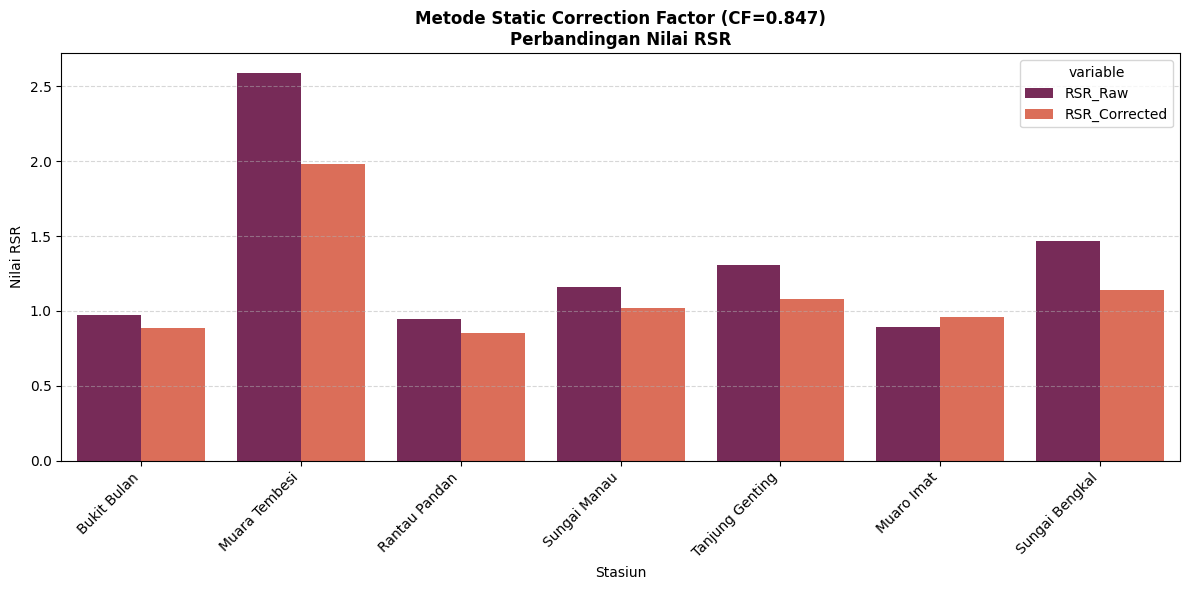

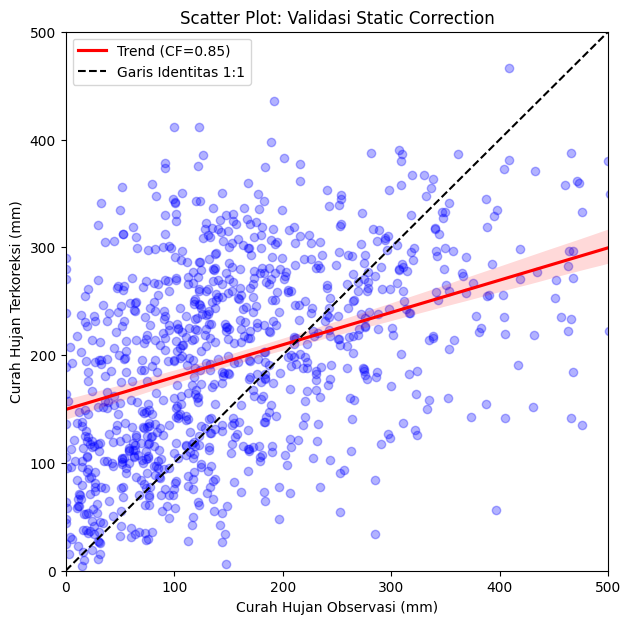

In [ ]:
# ==========================================
# BAGIAN 5: VISUALISASI
# ==========================================

# Grafik 1: RSR
plt.figure(figsize=(12, 6))
plot_data = summary.melt(id_vars='Stasiun', value_vars=['RSR_Raw', 'RSR_Corrected'])
sns.barplot(data=plot_data, x='Stasiun', y='value', hue='variable', palette='rocket')
plt.title(f'Metode Static Correction Factor (CF={CF_STATIC:.3f})\nPerbandingan Nilai RSR', fontweight='bold')
plt.ylabel('Nilai RSR')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Grafik 2: Scatter Plot dengan Garis Regresi
plt.figure(figsize=(7, 7))
sns.regplot(x=validasi_df['Observed'], y=validasi_df['Corrected'],
            scatter_kws={'alpha':0.3, 'color':'blue'}, line_kws={'color':'red', 'label': f'Trend (CF={CF_STATIC:.2f})'})
plt.plot([0, 500], [0, 500], 'k--', label='Garis Identitas 1:1')
plt.xlim(0, 500); plt.ylim(0, 500)
plt.xlabel('Curah Hujan Observasi (mm)')
plt.ylabel('Curah Hujan Terkoreksi (mm)')
plt.title('Scatter Plot: Validasi Static Correction')
plt.legend()
plt.show()